<a href="https://colab.research.google.com/github/igoravelli/brazilian_soccer_championship_analysis/blob/main/Goal_scoring_distribution_by_team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandasql
!pip install ipywidgets

import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets

data_table.enable_dataframe_formatter()
auth.authenticate_user()


project = 'brasileirao-362523'
schema = '3_gold'
location = 'US'

client = bigquery.Client(project=project, location=location)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00


# Extract data

In [2]:
# @title Get dimTeam data
dim_team = client.query(f"""
      SELECT * FROM `{project}.{schema}.dimTeam`
    """).to_dataframe()

dim_team.set_index('pk_team', inplace=True)
dim_team.head()

,team,state,stadium,coach,start_id,end_id
pk_team,,,,,,
1225,csa,AL,estadio_rei_pele,M._Ribeiro_Cabo,6513,6589
1226,csa,AL,estadio_rei_pele,A._Fucks,6601,6861
1227,csa,AL,estadio_rei_pele,G._Santos_Vasconcelo,6869,6879
1079,bahia,BA,itaipava_arena_fonte_nova,N/A,8,4612
1080,bahia,BA,itaipava_arena_fonte_nova,M._dos_Santos_Goncalves,4623,4730


In [3]:
# @title Get dimMatch data
dim_match = client.query(f"""
      SELECT * FROM `{project}.{schema}.dimMatch`
    """).to_dataframe()

dim_match.set_index('pk_match', inplace=True)
dim_match.head()

,stadium,away_team,home_team,round,match_date,championship_year,home_team_squad,away_team_squad,winner,loser
pk_match,,,,,,,,,,
1114,mane_garrincha,vasco,brasiliense,1,2005-04-24 18:10:00,2005,N/A,N/A,None,None
1148,boca_do_jacare,fluminense,brasiliense,4,2005-05-15 18:10:00,2005,N/A,N/A,fluminense,brasiliense
1167,boca_do_jacare,parana,brasiliense,6,2005-05-29 16:00:00,2005,N/A,N/A,brasiliense,parana
1183,mane_garrincha,corinthians,brasiliense,8,2005-06-18 16:00:00,2005,N/A,N/A,corinthians,brasiliense
1213,boca_do_jacare,athletico-pr,brasiliense,10,2005-07-03 18:10:00,2005,N/A,N/A,brasiliense,athletico-pr


In [4]:
# @title Get factEvents data
ft_events = client.query(f"""
      SELECT * FROM `{project}.{schema}.factEvents`
    """).to_dataframe()

ft_events.set_index('pk_fact_event', inplace=True)
ft_events.head()

,fk_match_id,fk_team_id,fk_calendar_id,fk_player_id,fk_stadium_id,event,minute,extra_time
pk_fact_event,,,,,,,,
2000001,4607,1268,20140419,14367,100104,goal,31,0
2000002,4607,1231,20140419,15053,100104,yellow,44,0
2000003,4607,1268,20140419,11742,100104,goal,45,0
2000004,4607,1268,20140419,14030,100104,goal,59,0
2000005,4607,1231,20140419,14206,100104,yellow,66,0


In [5]:
# @title Join dimTeam, dimMatch, factEvents
df_analysis = ft_events.merge(dim_team, left_on='fk_team_id', right_on='pk_team', how='inner').merge(dim_match, left_on='fk_match_id', right_on='pk_match', how='inner')

df_analysis = df_analysis[["championship_year","team","event","minute"]]

df_analysis = df_analysis[df_analysis["event"] == 'goal']

df_analysis.head()

,championship_year,team,event,minute
0,2014,fluminense,goal,31
1,2014,fluminense,goal,45
2,2014,fluminense,goal,59
8,2014,bahia,goal,8
11,2014,bahia,goal,74


# Transformations

In [6]:
# @title Select the year which the data will be analyzed

years = df_analysis["championship_year"].unique().tolist()

years.sort()

dropdown = widgets.Dropdown(options=years)

display(dropdown)

Dropdown(options=('2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'), value='2014')

In [7]:
# @title Goal scoring distribution analysis

selected_year = dropdown.value

df_year = df_analysis

df_year = df_year[df_year["championship_year"] == selected_year]

df_year.drop(["championship_year","event"], axis=1, inplace=True)

pivot_df = df_year.pivot(columns="team", values="minute")

list_goals = []

# Percorrer as colunas do DataFrame
for col_name in pivot_df.columns:
    list_aux = pivot_df[col_name].dropna().tolist()
    list_goals.append(list_aux)

<ipython-input-7-7225372570df>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year.drop(["championship_year","event"], axis=1, inplace=True)


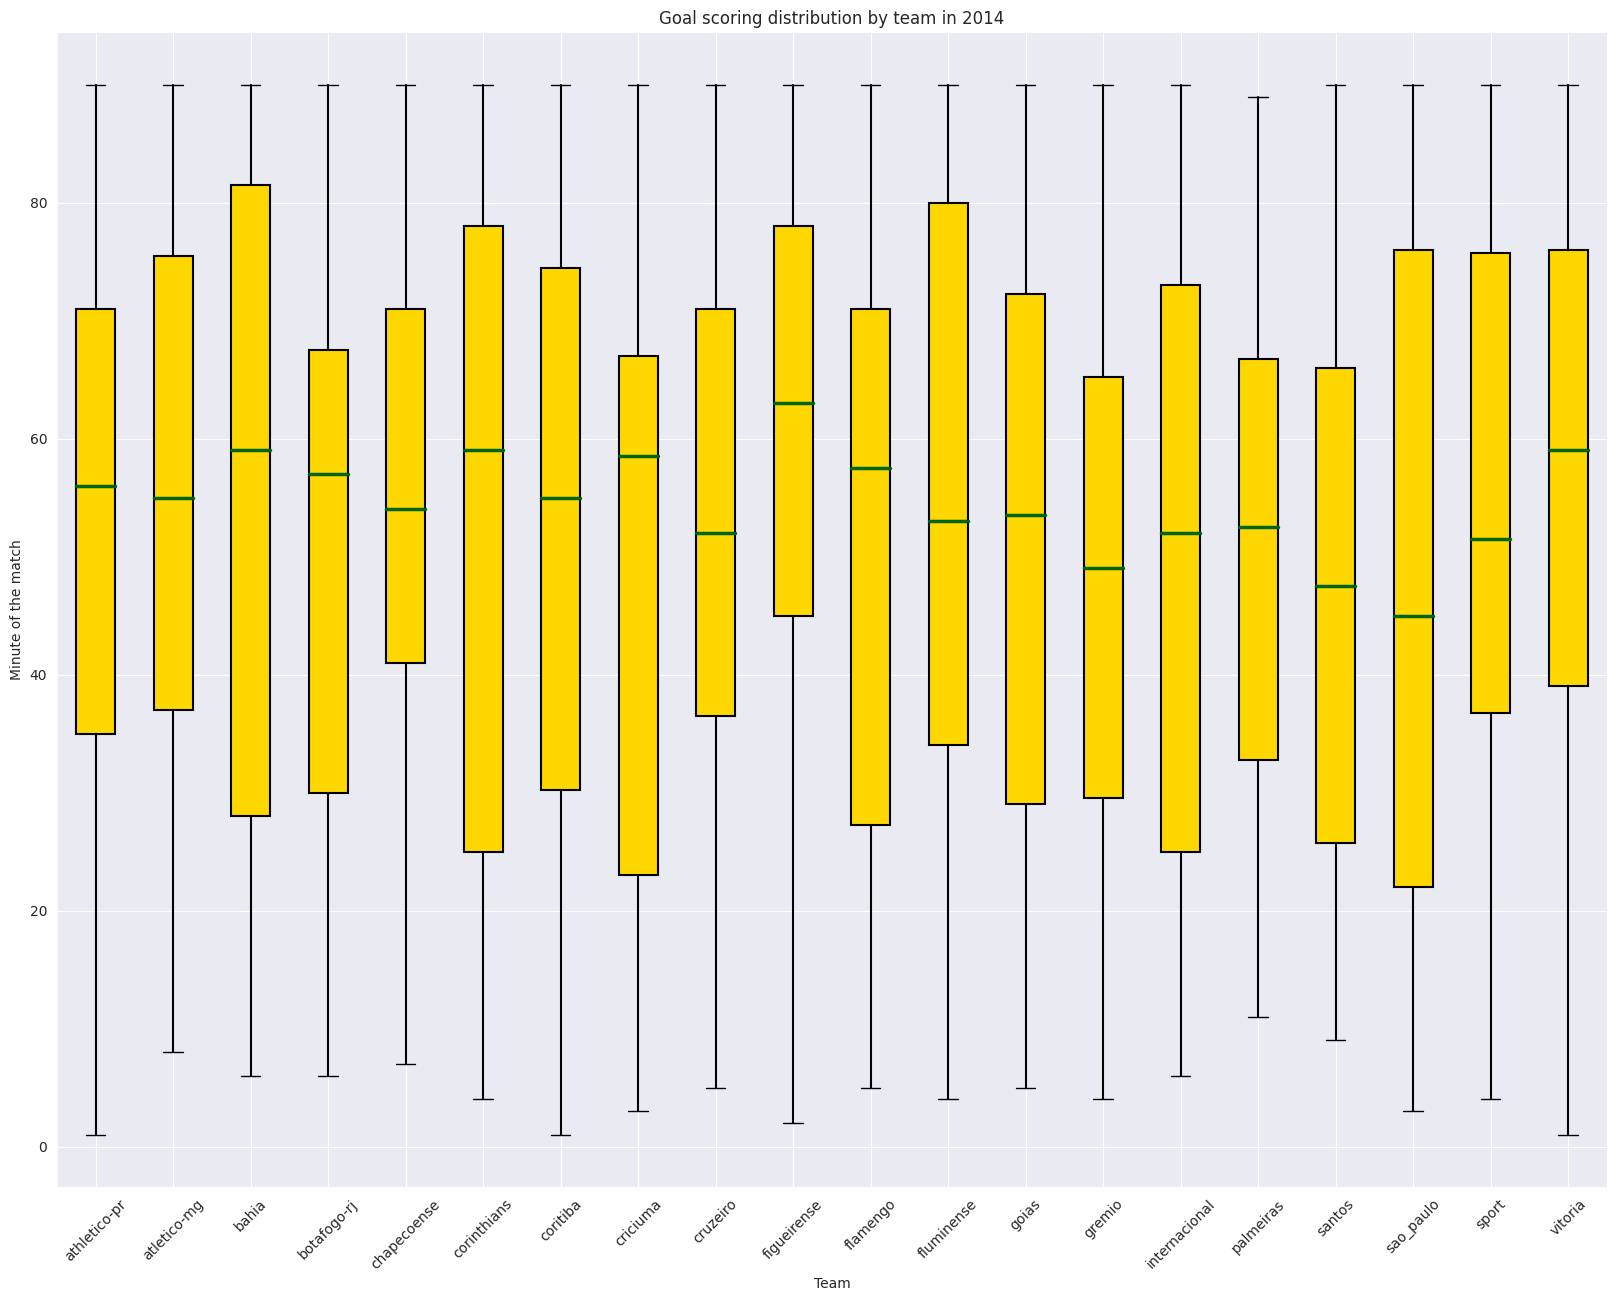

In [13]:
# @title Plot chart
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [18, 8]
sns.set_style("darkgrid")

whiskerprops = dict(linewidth=1.5)
boxprops = dict(linewidth=1.5, facecolor = "#FFD700")
medianprops = dict(linewidth=2.5, color = "#006400")

ax.boxplot(list_goals, patch_artist = True, boxprops = boxprops, medianprops = medianprops, whiskerprops = whiskerprops)

ax.set_xticklabels(pivot_df.columns, rotation=45)

title = f"Goal scoring distribution by team in {selected_year}"

ax.set_title(title)
ax.set_xlabel("Team")
ax.set_ylabel("Minute of the match")


plt.show()


# Conclusion

In this notebook, the distribution of goals per team throughout the championship in the selected year was analyzed. The Y-axis represents the minute during the game in which the goal was scored, and the X-axis represents the teams in the championship.

For the results, a boxplot visualization was used, which is a visual tool that summarizes the distribution of a dataset by displaying its median (green line on the chart), quartiles, and potential outliers. It provides insights into central tendency, spread, and skewness, offering a concise overview of data distribution.

Using the database from the year 2021 (the most recent), it can be observed that all the teams scored at least one goal at the beginning of the match and also at the end. However, when comparing the minute distribution, significant differences emerge. 'Ceara' has its fourth quartile concentrated at the end of the match, indicating a concentration of goals in the final minutes. Another example, 'Sport,' has its first quartile represented by a large whisker covering the entire first 45 minutes, which means that about 75% of the goals are scored after the first half.

These are a few examples of conclusions that can be extracted from the boxplots, illustrating how this information can be useful in a real analysis situation nad building an effective strategy based to the opponent's way of playing.